Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Requirement already satisfied: seaborn in /opt/conda/lib/python3.11/site-packages (0.13.2)

Requirement already satisfied: numpy!=1.24.0,>=1.20 in /opt/conda/lib/python3.11/site-packages (from seaborn) (1.26.4)

Requirement already satisfied: pandas>=1.2 in /opt/conda/lib/python3.11/site-packages (from seaborn) (2.2.3)

Requirement already satisfied: matplotlib!=3.6.1,>=3.4 in /opt/conda/lib/python3.11/site-packages (from seaborn) (3.9.3)

Requirement already satisfied: contourpy>=1.0.1 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (1.3.1)

Requirement already satisfied: cycler>=0.10 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (0.12.1)

Requirement already satisfied: fonttools>=4.22.0 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (4.55.3)

Requirement already satisfied: kiwisolver>=1.3.1 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (1.4.7)

Requirement already satisfied: packaging>=20.0 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (24.2)

Requirement already satisfied: pillow>=8 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (10.4.0)

Requirement already satisfied: pyparsing>=2.3.1 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (3.2.0)

Requirement already satisfied: python-dateutil>=2.7 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (2.9.0.post0)

Requirement already satisfied: pytz>=2020.1 in /opt/conda/lib/python3.11/site-packages (from pandas>=1.2->seaborn) (2023.3)

Requirement already satisfied: tzdata>=2022.7 in /opt/conda/lib/python3.11/site-packages (from pandas>=1.2->seaborn) (2024.2)

Requirement already satisfied: six>=1.5 in /opt/conda/lib/python3.11/site-packages (from python-dateutil>=2.7->matplotlib!=3.6.1,>=3.4->seaborn) (1.17.0)

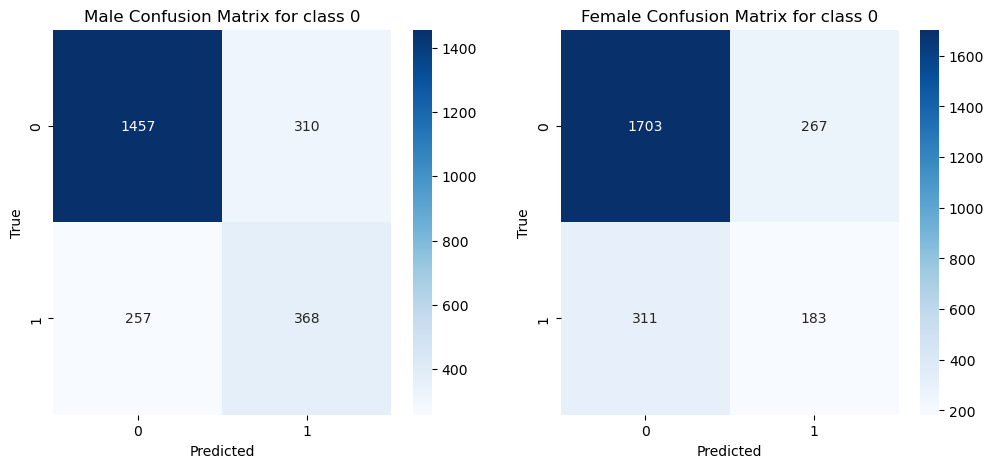

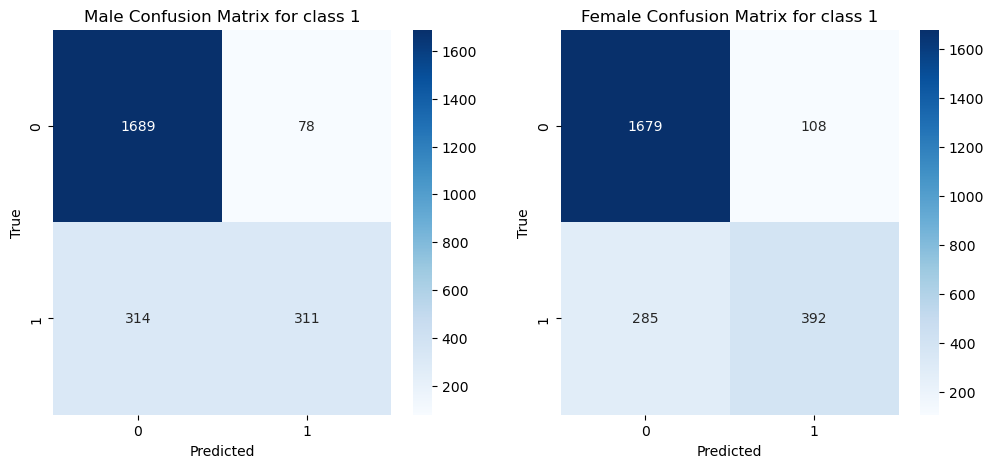

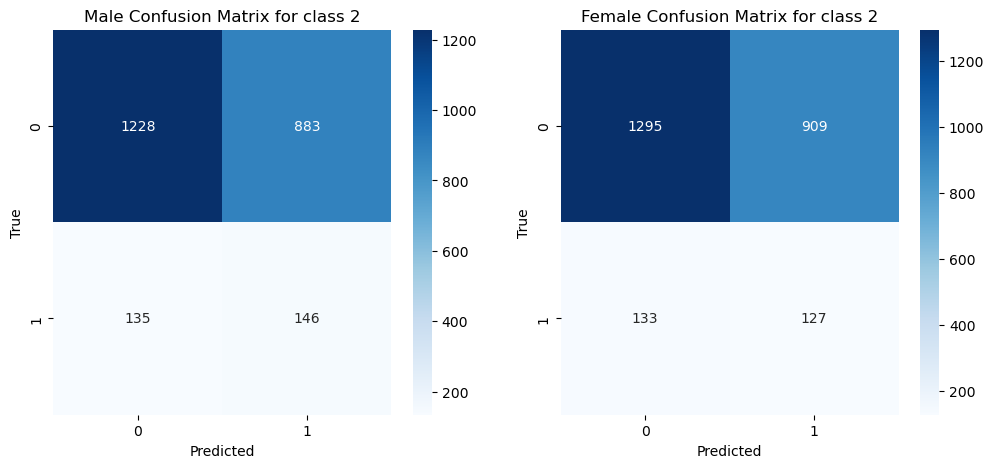

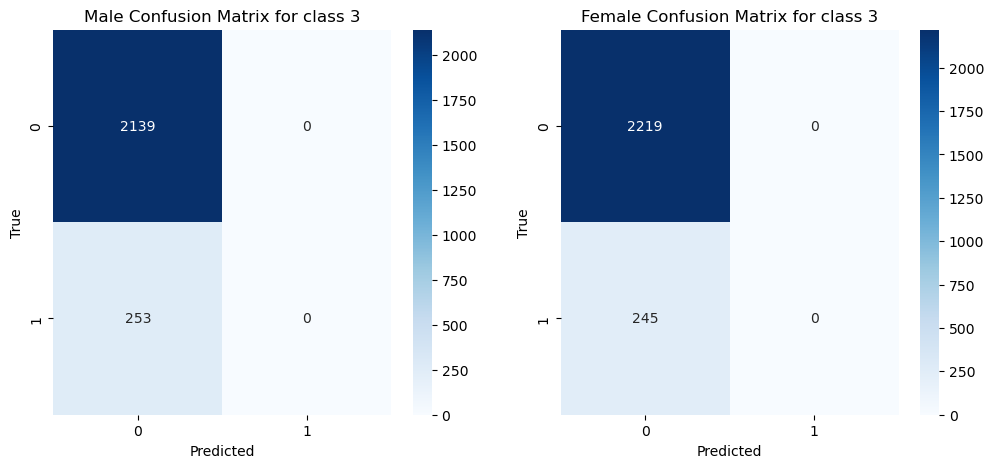

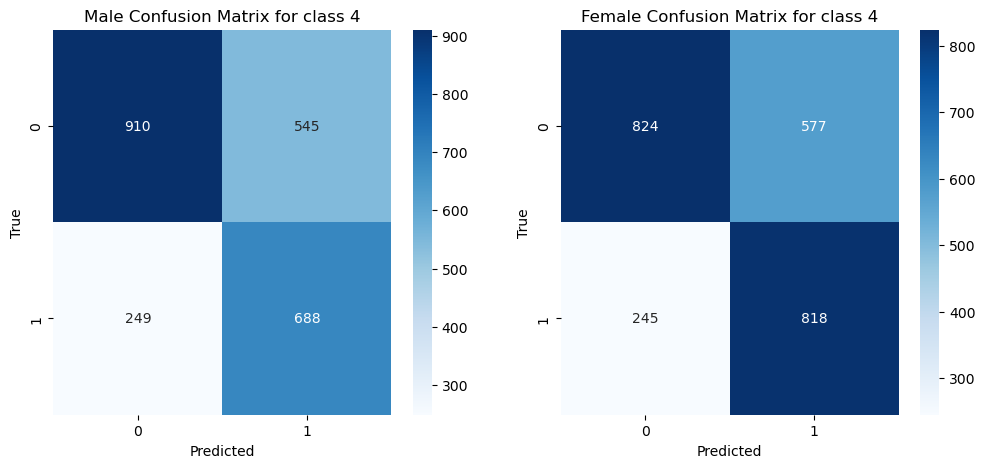

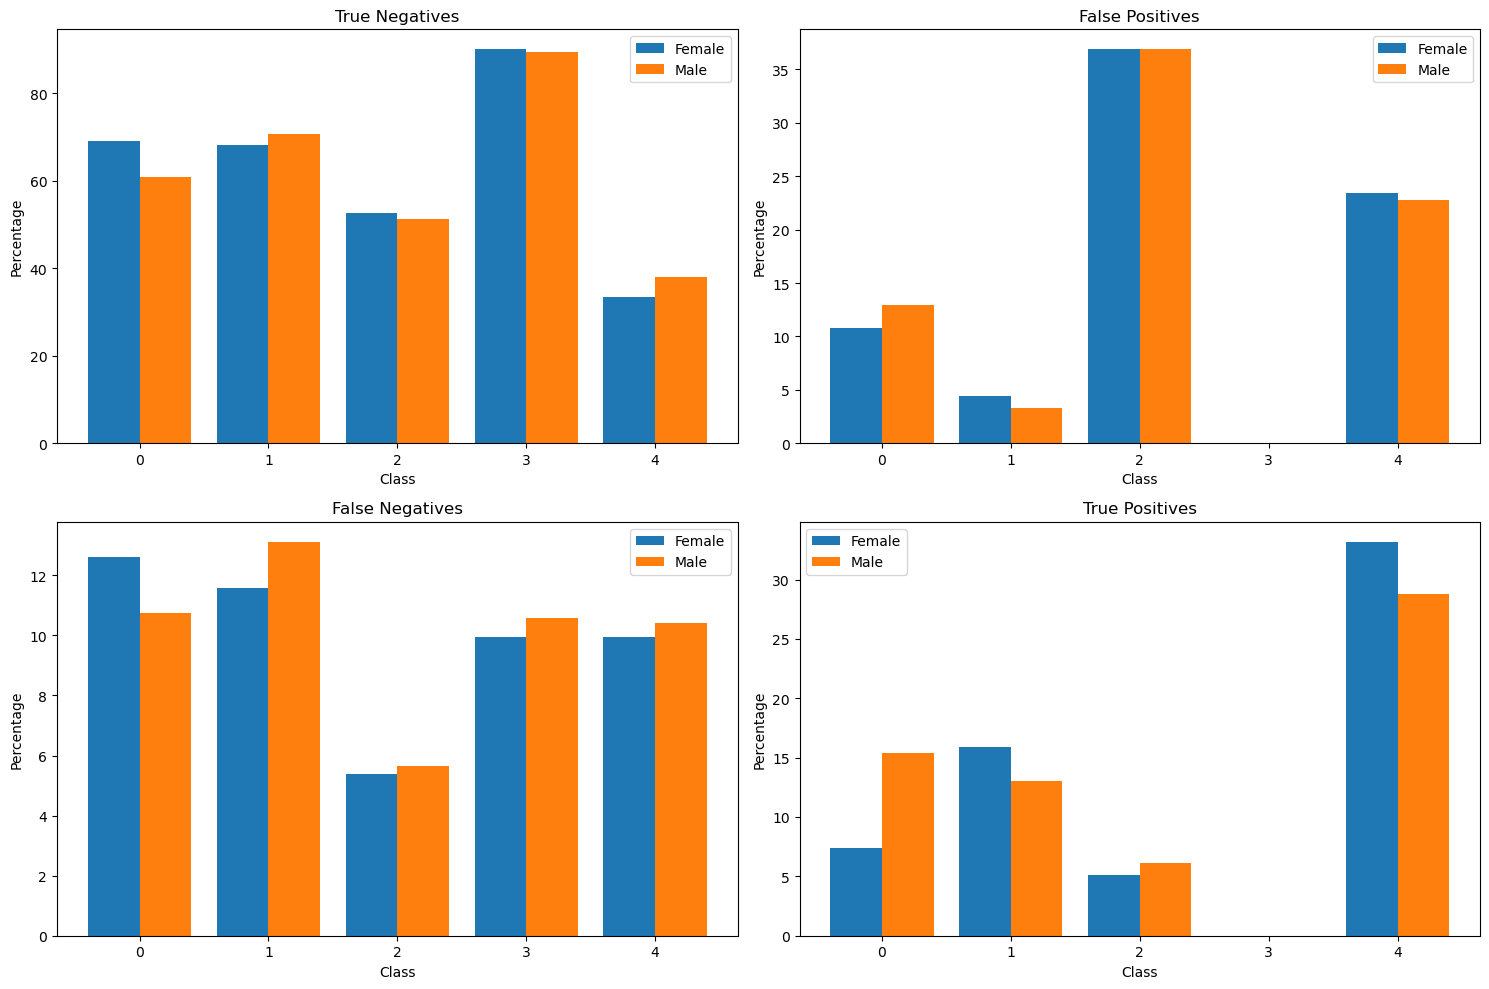

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import os
import pip
pip.main(['install','seaborn'])
import seaborn as sns
import matplotlib.pyplot as plt

base_dir = '../Arrays/'

test_images = np.load(os.path.join(base_dir, 'images.npy'))
test_labels = np.load(os.path.join(base_dir, 'labels.npy'))
test_image_names = np.load(os.path.join(base_dir, 'image_names.npy'))
csv_file = '../Arrays/BRAX2.csv'
data = pd.read_csv(csv_file)
results = np.load('../Arrays/Joint_results.npy')

def compute_confusion_matrices(gender):
    gender_data = data[data['PatientSex'] == gender]
    gender_image_indices = [os.path.basename(path) for path in gender_data['PngPath'].values]
    filtered_indices = [i for i, img_name in enumerate(test_image_names) if img_name in gender_image_indices]
    filtered_test_labels = [test_labels[i] for i in filtered_indices]
    filtered_results = results[filtered_indices]
    num_classes = len(test_labels[0])
    confusion_matrices = {}
    for class_idx in range(num_classes):
        true_labels = [label[class_idx] for label in filtered_test_labels]
        predicted_labels = [result[class_idx] for result in filtered_results]
        cm = confusion_matrix(true_labels, predicted_labels)
        confusion_matrices[class_idx] = cm
    return confusion_matrices, len(filtered_indices)

male_confusion_matrices, male_total = compute_confusion_matrices('M')
female_confusion_matrices, female_total = compute_confusion_matrices('F')

num_classes = len(test_labels[0])
for class_idx in range(num_classes):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(male_confusion_matrices[class_idx], annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Male Confusion Matrix for class {class_idx}')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    sns.heatmap(female_confusion_matrices[class_idx], annot=True, fmt='d', cmap='Blues', ax=axes[1])
    axes[1].set_title(f'Female Confusion Matrix for class {class_idx}')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    plt.show()


#Bar charts
def extract_confusion_matrix_breakdown(confusion_matrices, gender, total):
    breakdown = {'Class': [], 'Gender': [], 'TP': [], 'FP': [], 'TN': [], 'FN': []}
    for class_idx, cm in confusion_matrices.items():
        tp = cm[1, 1] / total * 100
        fp = cm[0, 1] / total * 100
        tn = cm[0, 0] / total * 100
        fn = cm[1, 0] / total * 100
        breakdown['Class'].append(class_idx)
        breakdown['Gender'].append(gender)
        breakdown['TP'].append(tp)
        breakdown['FP'].append(fp)
        breakdown['TN'].append(tn)
        breakdown['FN'].append(fn)
    return breakdown

male_breakdown = extract_confusion_matrix_breakdown(male_confusion_matrices, 'Male', male_total)
female_breakdown = extract_confusion_matrix_breakdown(female_confusion_matrices, 'Female', female_total)

breakdown_df = pd.concat([pd.DataFrame(male_breakdown), pd.DataFrame(female_breakdown)], ignore_index=True)

breakdown_df = breakdown_df.groupby(['Class', 'Gender']).sum().reset_index()

metrics = ['TN', 'FP', 'FN', 'TP']
titles = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    for gender in breakdown_df['Gender'].unique():
        gender_data = breakdown_df[breakdown_df['Gender'] == gender]
        ax.bar(gender_data['Class'] + (0.2 if gender == 'Male' else -0.2), gender_data[metric], width=0.4, label=gender)
    ax.set_title(titles[i])
    ax.set_xlabel('Class')
    ax.set_ylabel('Percentage')
    ax.legend()

plt.tight_layout()
plt.show()

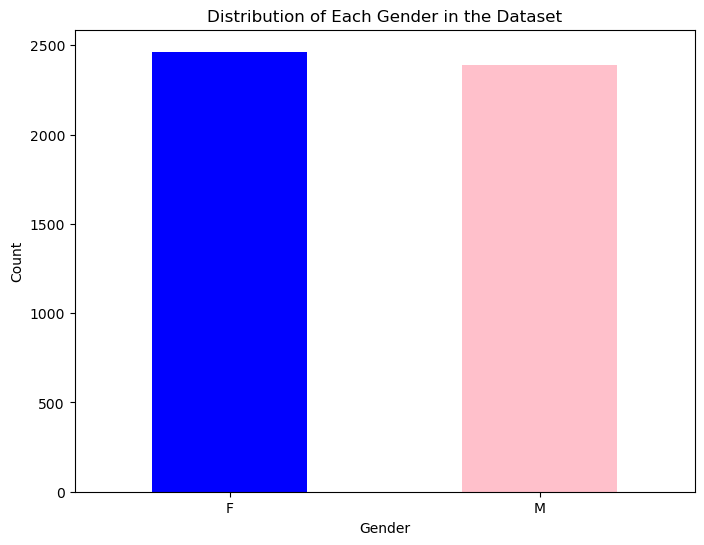

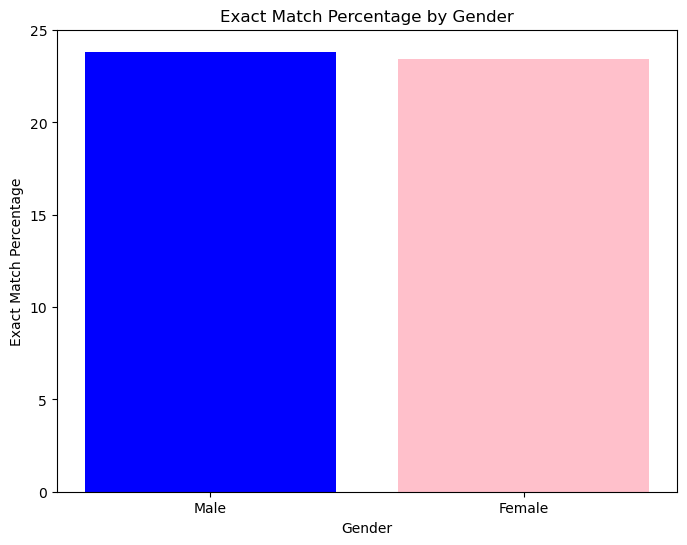

In [7]:
gender_counts = data['PatientSex'].value_counts()

fig, ax = plt.subplots(figsize=(8, 6))
gender_counts.plot(kind='bar', color=['blue', 'pink'], ax=ax)
ax.set_title('Distribution of Each Gender in the Dataset')
ax.set_xlabel('Gender')
ax.set_ylabel('Count')
plt.xticks(rotation=0)
plt.show()

def calculate_exact_match_percentage(true_labels, predicted_labels):
    if true_labels.shape != predicted_labels.shape:
        raise ValueError("The shape of true_labels and predicted_labels must be the same.")
    exact_matches = np.all(true_labels == predicted_labels, axis=1)
    exact_match_percentage = np.mean(exact_matches) * 100
    return exact_match_percentage

def compute_exact_match_percentage(gender):
    gender_data = data[data['PatientSex'] == gender]
    gender_image_indices = [os.path.basename(path) for path in gender_data['PngPath'].values]
    filtered_indices = [i for i, img_name in enumerate(test_image_names) if img_name in gender_image_indices]
    filtered_test_labels = np.array([test_labels[i] for i in filtered_indices])
    filtered_results = results[filtered_indices]
    return calculate_exact_match_percentage(filtered_test_labels, filtered_results)

male_exact_match_percentage = compute_exact_match_percentage('M')
female_exact_match_percentage = compute_exact_match_percentage('F')

fig, ax = plt.subplots(figsize=(8, 6))
genders = ['Male', 'Female']
percentages = [male_exact_match_percentage, female_exact_match_percentage]
ax.bar(genders, percentages, color=['blue', 'pink'])
ax.set_title('Exact Match Percentage by Gender')
ax.set_xlabel('Gender')
ax.set_ylabel('Exact Match Percentage')
plt.show()

